# Comparison with CaImAn
Here we run the Caiman algorithm as it is and then initializing it using the Agonia boxes or center of cells to segment and compare the extracted traces.

In [67]:
import pandas as pd
import pickle


import bokeh.plotting as bpl
import cv2
import glob
import logging
import matplotlib.pyplot as plt
import numpy as np
import os

try:
    cv2.setNumThreads(0)
except():
    pass

try:
    if __IPYTHON__:
        # this is used for debugging purposes only. allows to reload classes
        # when changed
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    pass

import caiman as cm
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.source_extraction.cnmf import params as params
from caiman.utils.utils import download_demo
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
bpl.output_notebook()

import xml.etree.ElementTree as et 
import pandas as pd
from matplotlib.patches import Rectangle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

### Load data and play movie

In [84]:
fnames = ['/home/pedro/Work/AGOnIA/Boxes-data/501271265_5000.tif']  # filename to be processed
with open('/home/pedro/Work/AGOnIA/Boxes-data/501271265_boxes.pkl','rb') as f:
    cajas = pickle.load(f)
    f.close()
ROIs = np.empty(np.shape(np.array(cajas[:,:4]))).astype('int')
ROIs[:,[0,2]] = np.array(cajas[:,[0,2]].astype('int'))
ROIs[:,[1,3]] = np.array(cajas[:,[1,3]].astype('int'))
cnm = cnmf.load_CNMF('/home/pedro/Work/AGOnIA/Boxes-data/analysis_results.hdf5')


/home/pedro/anaconda3/envs/caiman/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [ ]:
fnames = ['/home/pedro/Work/AGOnIA/Boxes-data/Caiman_test/866.avi']
cnm = cnmf.load_CNMF('/home/pedro/caiman_data/demos/notebooks/analysis_results.hdf5')
xtree = et.parse("/home/pedro/Work/AGOnIA/Boxes-data/Caiman_test/866.xml")
xroot = xtree.getroot()

df_cols = ["Cell", "xmin", "ymin", "xmax" , 'ymax']
rows = []

for i, node in enumerate(xroot[6:]): 
    box = i
    xmin = int(node.find('bndbox').find('xmin').text)
    ymin = int(node.find('bndbox').find('ymin').text)
    xmax = int(node.find('bndbox').find('xmax').text)
    ymax = int(node.find('bndbox').find('ymax').text)
    
    rows.append({"Cell": box, "xmin": xmin, 
                 "ymin": ymin, "xmax": xmax,
                 "ymax": ymax})

Box_agonia = pd.DataFrame(rows, columns = df_cols)
    

In [73]:
single_movie = cm.load(fnames)
print(single_movie.shape)

100%|██████████| 1/1 [00:09<00:00,  9.25s/it]


(5000, 512, 512)


In [24]:
display_movie = True
if display_movie:
    m_orig = cm.load_movie_chain(fnames)
    ds_ratio = 0.2
    m_orig.resize(1, 1, ds_ratio).play(
        q_max=99.5, fr=5, magnification=2)

100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


### Background for boxes
Calculate the median of the recording and the sum of all the cells detected by Caiman. 
Plot AGONIA boxes on top of them. 

In [87]:
med = np.median(single_movie,axis=0)
caiman_cells = [np.reshape(cnm.estimates.A[:,i].toarray(), cnm.estimates.dims, order='F') for i in range(cnm.estimates.A.shape[1])]

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(15,7))
ax[0].imshow(med,cmap='gray')
for i in range(Box_agonia['Cell'].iloc[-1]):
    rect = Rectangle((Box_agonia['xmin'][i],Box_agonia['ymin'][i]), Box_agonia['xmax'][i]-Box_agonia['xmin'][i],
          Box_agonia['ymax'][i]-Box_agonia['ymin'][i],color='r',fill=False)
    ax[0].add_patch(rect)
ax[0].set_title('AGONIA over median',fontsize=15)
ax[1].imshow(np.sum(caiman_cells,axis=0))
for i in range(Box_agonia['Cell'].iloc[-1]):
    rect = Rectangle((Box_agonia['xmin'][i],Box_agonia['ymin'][i]), Box_agonia['xmax'][i]-Box_agonia['xmin'][i],
          Box_agonia['ymax'][i]-Box_agonia['ymin'][i],color='r',fill=False)
    ax[1].add_patch(rect)
ax[1].set_title('AGONIA CaImAn detection',fontsize=15)


Text(0.5,1,'AGONIA CaImAn detection')

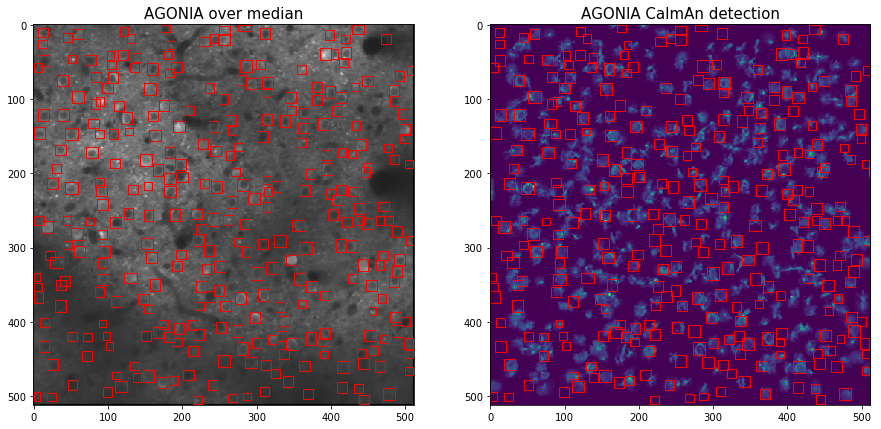

In [88]:
fig,ax = plt.subplots(1,2,figsize=(15,7))
ax[0].imshow(med,cmap='gray')
for i in range(ROIs.shape[0]):
    rect = Rectangle((ROIs[i,0],ROIs[i,1]), ROIs[i,2]-ROIs[i,0],
          ROIs[i,3]-ROIs[i,1],color='r',fill=False)
    ax[0].add_patch(rect)
ax[0].set_title('AGONIA over median',fontsize=15)

ax[1].imshow(np.sum(caiman_cells,axis=0))
for i in range(ROIs.shape[0]):
    rect = Rectangle((ROIs[i,0],ROIs[i,1]), ROIs[i,2]-ROIs[i,0],
          ROIs[i,3]-ROIs[i,1],color='r',fill=False)
    ax[1].add_patch(rect)
ax[1].set_title('AGONIA CaImAn detection',fontsize=15)
